# Smart Cropping with Python 

Based on code by jGonzalez on https://github.com/epixelic/python-smart-crop

In [3]:
import cv2 # This imports openCV
import os # This imports the OS library to load the image
import math # This imports the math library for certain calculations
from matplotlib import pyplot as plt # I use Matplotlib to print the images in the Notebook, so probably you won't need it

In [4]:
# Algorithm parameters
COMBINE_FACE_WEIGHT = 10
COMBINE_FEATURE_WEIGHT = 10
FEATURE_DETECT_MAX_CORNERS = 50
FEATURE_DETECT_QUALITY_LEVEL = 0.1
FEATURE_DETECT_MIN_DISTANCE = 10
FACE_DETECT_REJECT_LEVELS = 1.3
FACE_DETECT_LEVEL_WEIGHTS = 5

In [5]:
#This loads the haar cascade model to do face detection
cascade_path = "haarcascade_frontalface_default.xml"

In [6]:
#This is hte code to detect the faces and calculate the "center" of the image based of it
def center_from_faces(matrix):
    
    #This is the OpenCV2 code that detects the faces 
    face_cascade = cv2.CascadeClassifier(cascade_path)
    faces = face_cascade.detectMultiScale(matrix, FACE_DETECT_REJECT_LEVELS, FACE_DETECT_LEVEL_WEIGHTS)

    # Variables initialization
    x, y = (0, 0)
    weight = 0

    # This is the code that detects the x,y points in the picture based in the faces
    for (x, y, w, h) in faces:
        weight += w * h
        x += (x + w / 2) * w * h
        y += (y + h / 2) * w * h

    if len(faces) == 0:
        return False

    return {
        'x': x / weight,
        'y': y / weight,
        'count': len(faces)
    }

In [7]:
#This is the method to crop using corners, i.e. picture features

def center_from_good_features(matrix):

    #This is the OpenCV code that detects the corners
    corners = cv2.goodFeaturesToTrack(matrix, FEATURE_DETECT_MAX_CORNERS, FEATURE_DETECT_QUALITY_LEVEL, 
                                      FEATURE_DETECT_MIN_DISTANCE)

     # Variables initialization
    x, y = (0, 0)
    weight = 0
    
    #This is the code that detects the x,y parameters based on the corners found
    for point in corners:
        weight += 1
        x += point[0][0]
        y += point[0][1]

    return {
        'x': x / weight,
        'y': y / weight,
        'count': weight
    }

In [8]:
# This function detects the center of the image
def auto_center(matrix):
    
    #First it tries to detect human faces
    face_center = center_from_faces(matrix)
    center = {'x': 0, 'y': 0}

    if not face_center:
        #If no human faces are dtected it uses corners
        center = center_from_good_features(matrix)
    else:
        #If faces are detected it uses a combination of faces and corners
        features_center = center_from_good_features(matrix)
        face_w = features_center['count'] * COMBINE_FACE_WEIGHT
        feat_w = features_center['count'] * COMBINE_FEATURE_WEIGHT
        t_w = face_w + feat_w
        center['x'] = (face_center['x'] * face_w + features_center['x'] * feat_w) / t_w
        center['y'] = (face_center['y'] * face_w + features_center['y'] * feat_w) / t_w
    return center

In [9]:
# Before cropping, the target image is resized to the percentage required
def auto_resize(image, target_width, target_height):
    height, width, depth = image.shape

    ratio = target_width / width
    w, h = width * ratio, height * ratio
    p = 1

    # if there is still height or width to compensate, let's do it
    if w - target_width < 0 or h - target_height < 0:
        ratio = max(target_width / w, target_height / h)
        w, h = w * ratio, h * ratio
        p = 2

    #OpenCV image resize Method
    image = cv2.resize(image, (int(w), int(h)))
 
    return image

In [10]:
# This function calculates the image cropping coordenates
def exact_crop(center, original_width, original_height, target_width, target_height):
    top = max(center['y'] - math.floor(target_height / 2), 0)
    offset_h = top + target_height
    if offset_h > original_height:
        # overflowing
        # print("Top side over by ", offsetH - original_height)
        top = top - (offset_h - original_height)
    top = max(top, 0)
    bottom = min(offset_h, original_height)

    left = max(center['x'] - math.floor(target_width / 2), 0)
    offset_w = left + target_width
    if offset_w > original_width:
        # overflowing
        # print("Left side over by ", offsetW - original_width)
        left = left - (offset_w - original_width)
    left = max(left, 0)
    right = min(left + target_width, original_width)

    return {
        'left': left,
        'right': right,
        'top': top,
        'bottom': bottom
    }

In [16]:
# MAIN Smart Crop function
def smartCrop(originalPath):
    # Load original image using OpenCV
    original = cv2.imread(originalPath)
    # Resize the original image to match the desired size as much as possible
    resized = auto_resize(original, target_width, target_height)
    # Load the resized image into matrix using openCV. By default the image is gray scale (smaller matrix)
    matrix = cv2.cvtColor(resized, cv2.COLOR_BGR2GRAY)
    # Get the height, widht and depth from the resized image 
    height, width, depth = resized.shape
    # Get the center of the image, running the matrix throught he face detection and feature detection algorithms
    center = auto_center(matrix)
    # Then calculate the exact cropping position based on the center + compensation to get to desired size
    crop_pos = exact_crop(center, width, height, target_width, target_height)
    # Create a new image cropping the resized image in the coordinates calculated before 
    cropped = resized[int(crop_pos['top']): int(crop_pos['bottom']), int(crop_pos['left']): int(crop_pos['right'])]
    # Write the image to disk
    cv2.imwrite(savePath, cropped)
    
    return cropped

In [12]:
# Set target widht, height and original image
target_height = 742
target_width = 1320
imagefile = "113179.jpg"

In [13]:
# Set the path where to load the images from 
originalPath = "original/"+imagefile
# Set the path where to load manually resized images from (not used in any calculation just for reference)
resizedPath = "resized/"+imagefile
# Set the path to save the generated, smart-crop images
savePath = "generated/"+imagefile

In [17]:
# Run the smart crop on required image

smartCrop(originalPath)

array([[[140,  88,  52],
        [141,  89,  53],
        [140,  88,  52],
        ...,
        [144,  88,  53],
        [144,  88,  53],
        [144,  88,  53]],

       [[141,  89,  53],
        [140,  88,  52],
        [141,  89,  53],
        ...,
        [144,  88,  53],
        [144,  88,  53],
        [144,  87,  53]],

       [[140,  88,  52],
        [141,  89,  53],
        [140,  88,  52],
        ...,
        [144,  88,  53],
        [144,  88,  53],
        [143,  87,  53]],

       ...,

       [[141, 173, 184],
        [150, 181, 192],
        [151, 183, 194],
        ...,
        [153, 183, 191],
        [125, 150, 159],
        [133, 155, 163]],

       [[150, 182, 194],
        [148, 181, 194],
        [146, 178, 190],
        ...,
        [128, 145, 152],
        [163, 197, 202],
        [137, 163, 163]],

       [[147, 179, 190],
        [148, 180, 191],
        [148, 180, 191],
        ...,
        [129, 145, 147],
        [132, 145, 152],
        [125, 138, 141]]

(<matplotlib.image.AxesImage at 0x7fc64b98e710>, (2068, 3866, 3))

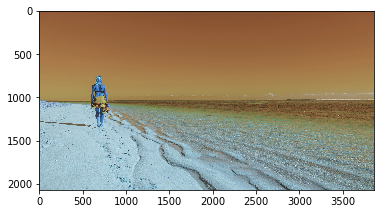

In [24]:
#Show the original image without resizing
original = cv2.imread(originalPath)
plt.imshow(original), original.shape

(<matplotlib.image.AxesImage at 0x7fc649314450>, (742, 1320, 3))

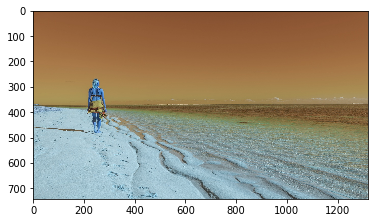

In [26]:
#Show the manually resized image, as provided by Expedia team
manual = cv2.imread(savePath)
plt.imshow(manual), manual.shape

(<matplotlib.image.AxesImage at 0x7fc64794a750>, (742, 1320, 3))

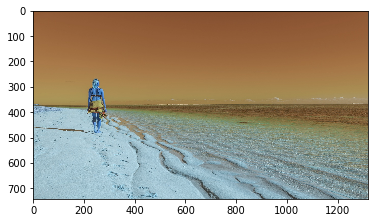

In [27]:
# Show the generated image, created using the smart crop function
generated = cv2.imread(savePath)
plt.imshow(generated), generated.shape